In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37795")
client

<Client: 'tcp://127.0.0.1:37795' processes=8 threads=40, memory=157.39 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import os.path as op
import os
import xrft
import xwavelet
import gsw
import time
from xhistogram.xarray import histogram as xhist
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 1  # 
yystart = 0
ntimes[yystart,dd:]

array([1423440, 1425600, 1427760, 1429920, 1432080, 1434240, 1436400,
       1438560, 1440720, 1442880, 1445040, 1447200, 1449360, 1451520,
       1453680, 1455840, 1458000, 1460160, 1462320, 1464480, 1466640,
       1468800, 1470960, 1473120, 1475280, 1477440, 1479600, 1481760,
       1483920, 1486080, 1488240, 1490400, 1492560, 1494720, 1496880,
       1499040, 1501200, 1503360, 1505520, 1507680, 1509840, 1512000,
       1514160, 1516320, 1518480, 1520640, 1522800, 1524960, 1527120,
       1529280, 1531440, 1533600, 1535760, 1537920, 1540080, 1542240,
       1544400, 1546560, 1548720, 1550880, 1553040, 1555200, 1557360,
       1559520, 1561680, 1563840, 1566000, 1568160, 1570320, 1572480,
       1574640, 1576800])

In [6]:
xchunk = 100
ychunk = 100
dCs = 1e-5
Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs
Cs

/tmp/ipykernel_14439/558776382.py:4: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs


<xarray.DataArray 'Cs' (Z: 46)>
dask.array<open_dataset-c34d5da5d0597f6f1f59084e0cf2eaadCs, shape=(46,), dtype=float32, chunksize=(46,), chunktype=numpy.ndarray>
Coordinates:
    PHrefC   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    drF      (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    iter     int64 ...
    rhoRef   (Z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    time     timedelta64[ns] ...

In [7]:
dsgrd = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,years[0])), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                     iters=ntimes[0,0],
                     prefix=['diag_ocnSnap'], delta_t=2e2,
                    ).sel(YC=slice(yNstart-12**-1,yend+2*12**-1),
                          YG=slice(yNstart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
dsgrd

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 423, XG: 1000, YG: 423, Z: 46, Zp1: 47, Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3290 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 14.92 15.0 15.08 15.17 15.25 ... 49.83 49.92 50.0 50.08
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 14.96 15.04 15.13 15.21 15.29 ... 49.88 49.96 50.04 50.13
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 100, 100), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(100, 100), meta=np.ndarray>
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [1]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))


yy = yystart

for year in years[yystart:]:
    if year == years[yystart]:
        mtimes = ntimes[yy,dd+1:]
    else:
        mtimes = ntimes[yy]
    for itime in mtimes:
        
#         dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
#                                    % (year,len(nmembs),itime))
#                           ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
#                                                 'YC':ychunk,'YG':ychunk})
        
        for nmemb in nmembs:
            if nmemb == 0:
                ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                             % (nmemb,year)), 
                                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                     prefix=['diag_ocnTave'], delta_t=2e2,
                                     iters=itime, 
                                    ).sel(YC=slice(yNstart-12**-1,yend+12**-1),
                                          YG=slice(yNstart-12**-1,yend+12**-1)
                                         ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                               'YC':ychunk,'YG':ychunk})
            else:
                ds = xr.concat([ds, 
                                open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                        % (nmemb,year)), 
                                                grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                prefix=['diag_ocnTave'], delta_t=2e2,
                                                iters=itime, 
                                               ).sel(YC=slice(yNstart-12**-1,yend+12**-1),
                                                     YG=slice(yNstart-12**-1,yend+12**-1)
                                                    ).isel(time=0).chunk({'XC':xchunk,'XG':xchunk,
                                                                          'YC':ychunk,'YG':ychunk})
                               ], dim='nmemb')
        
        ds = ds.chunk({'nmemb':6})
        ds.coords['nmemb'] = ('nmemb',nmembs)
        
        v = ds.VVEL.where(ds.maskS!=0.)
        u = ds.UVEL.where(ds.maskW!=0.)
        theta = ds.THETA.where(ds.maskC!=0.)
        salt = ds.SALT.where(ds.maskC!=0.)
        
        grid = Grid(ds, periodic=['X'])
        rho_til = grid.interp(rhoConst*(1. - grav*(-grid.cumsum((Cs+dCs)**-2*ds.drF, 'Z',
                                                                boundary='extend')
                                                  )),
                              'Z', boundary='extend'
                             )
        pres = rhoConst*grav*(-ds.Z) * 1e-4
        rho = xr.apply_ufunc(densjmd95, salt, theta, 
                             pres, 
                             dask='parallelized', output_dtypes=[float,]
                            )
        b = -(rho - rho_til) / rhoConst
        
        zeta = grid.interp(grid.interp((grid.diff(v*ds.dyC,'X')
                                        - grid.diff(u*ds.dxC,'Y',boundary='extend')
                                       ) / ds.rAz,'X'
                                      ),'Y',boundary='extend'
                          )
        b_z = grid.interp(-grid.diff(b,'Z',boundary='extend') 
                          / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                          'Z',boundary='extend')
        b_y = grid.interp(grid.diff(b,'Y',boundary='extend') / ds.dyC,'Y',boundary='extend')
        b_x = grid.interp(grid.diff(b,'X') / ds.dxC,'X',boundary='extend')
        v_z = grid.interp(-grid.diff(v,'Z',boundary='extend') 
                          / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                          'Z',boundary='extend')
        u_z = grid.interp(-grid.diff(u,'Z',boundary='extend') 
                          / ds.drC.data[np.newaxis,:-1,np.newaxis,np.newaxis],
                          'Z',boundary='extend')
        f = xr.apply_ufunc(gsw.f, ds.YC)
        
        PVv = ((zeta+f)*b_z).reset_coords(drop=True)
        PVh = (-grid.interp(v_z,'Y',boundary='extend')*b_x 
               + grid.interp(u_z,'X')*b_y
              ).reset_coords(drop=True)
        PVvp = PVv - PVv.mean('nmemb',skipna=True).compute()
        PVhp = PVh - PVh.mean('nmemb',skipna=True).compute()
        
        if itime == mtimes[0]:
            print(PVv, PVh)
            (PVv + PVh).isel(Z=0).mean('nmemb',skipna=True).plot(vmax=1e-10)
            plt.show()
        
        dsave = PVvp.to_dataset(name='pEPVv')
        dsave['pEPVh'] = PVhp
        dsave.pEPVv.encoding = {}
        dsave.pEPVh.encoding = {}
        dsave.chunk({'nmemb':6,'Z':1,'XC':xchunk,'YC':ychunk}).to_zarr(op.join(tdgs,
                                                    '5Dave/run%4d/EddyErtelPV/%2dmembers/15N-50N_%010d.zarr'
                                                            % (year,len(nmembs),itime)), mode='w'
                                                   )

        dsave.close()
        ds.close()
        print(itime)
        
    yy += 1
#     print(year)

In [8]:
ds = xr.open_zarr(op.join(tdgs,
                          '5Dave/run%4d/EddyErtelPV/%2dmembers/15N-50N_%010d.zarr'
                          % (years[0],48,ntimes[0,0]))
                 )
ds

,Array,Chunk
Bytes,6.94 GiB,468.75 kiB
Shape,"(48, 46, 422, 1000)","(6, 1, 100, 100)"
Count,18401 Tasks,18400 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,6.94 GiB,468.75 kiB
Shape,"(48, 46, 422, 1000)","(6, 1, 100, 100)"
Count,18401 Tasks,18400 Chunks
Type,float64,numpy.ndarray


In [9]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

/tmp/ipykernel_14439/2268255130.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,None)),
/tmp/ipykernel_14439/2268255130.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,None)),


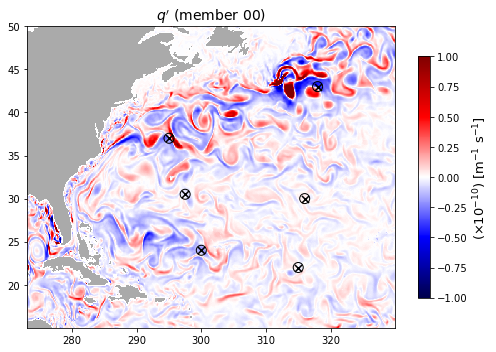

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)
im = ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,None)),
                   (ds.pEPVh + ds.pEPVv).isel(nmemb=0,Z=0).sel(XC=slice(273,330),YC=slice(15,None))*1e10, 
                   vmax=1, vmin=-1, cmap='seismic', rasterized=True
                  )
ax.pcolormesh(ds.XC.sel(XC=slice(273,330)), ds.YC.sel(YC=slice(15,None)),
              dsgrd.maskInC.where(dsgrd.maskInC!=1.).sel(XC=slice(273,330),YC=slice(15,50+12**-1)),
              vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax.scatter(xs, ys, marker='x', s=50, c='k')
ax.scatter(xs, ys, marker='o', s=100, facecolors='none', edgecolors='k')
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"$(\times 10^{-10})$ [m$^{-1}$ s$^{-1}$]", fontsize=13)
ax.set_title(r"$q'$ (member 00)", fontsize=14)
plt.savefig(op.join(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/EPVp_member00.pdf')))